# Autoencoders

В этом ноутбуке мы будем тренировать автоэнкодеры кодировать лица людей. Для этого возьмем следующий датасет: "Labeled Faces in the Wild" (LFW) (http://vis-www.cs.umass.edu/lfw/). Код для скачивания и загрузки датасета написан за вас в файле get_dataset.py


# Vanilla Autoencoder (2 балла)

## Prepare the data


In [1]:
import numpy as np
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
import torch
from torchvision import transforms
import torchvision

import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

from tqdm import tqdm

In [2]:
# The following line fetches you two datasets: images, usable for autoencoder training and attributes.
# Those attributes will be required for the final part of the assignment (applying smiles), so please keep them in mind
from get_dataset import fetch_dataset
data, attrs = fetch_dataset()

In [3]:
IMAGE_H = data.shape[1]
IMAGE_W = data.shape[2]
# у нас цветные изображения
N_CHANNELS = 3

TRAIN_SIZE = 10000
VAL_SIZE = data.shape[0] - TRAIN_SIZE

In [4]:
# First checking if GPU is available
train_on_gpu=torch.cuda.is_available()

if(train_on_gpu):
    print('Training on GPU.')
else:
    print('No GPU available, training on CPU.')
       
DEVICE = torch.device('cuda' if train_on_gpu else 'cpu')

Training on GPU.



Разбейте выборку картинок на train и val:

In [5]:
X_train = data[:TRAIN_SIZE]
X_val = data[TRAIN_SIZE:VAL_SIZE+TRAIN_SIZE]

Напишем вспомогательную функцию, которая будет выводить n_row $\cdot$ n_col первых картинок в массиве images:

In [6]:
def plot_gallery(images, h, w, n_row=3, n_col=6):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.5 * n_col, 1.7 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        try:
            plt.imshow(images[i].reshape((h, w, 3)), cmap=plt.cm.gray, vmin=-1, vmax=1, interpolation='nearest')
            plt.xticks(())
            plt.yticks(())
        except:
            pass

In [7]:
def plot_samples(sam1, sam2):
    sam1 = sam1[0].cpu().detach().numpy()
    sam2 = sam2[0].cpu().detach().numpy()
   
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(5, 3))
    axes[0].imshow(np.rollaxis(sam1, 0, 3))
    axes[1].imshow(np.rollaxis(sam2, 0, 3))
    fig.tight_layout()

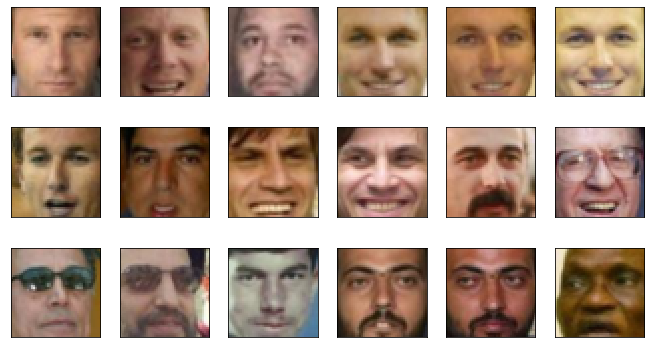

In [8]:
plot_gallery(X_train, IMAGE_H, IMAGE_W)

In [9]:
X_train = torch.FloatTensor(np.rollaxis(X_train, 3, 1) / 255)
X_val = torch.FloatTensor(np.rollaxis(X_val, 3, 1) / 255)

## Autoencoder

Why to use all this complicated formulaes and regularizations, what is the need for variational inference? To analyze the difference, let's first train just an autoencoder on the data:
<img src="https://i.imgur.com/nVJAtMT.png" alt="Autoencoder">

In [10]:
inp_size=X_train.shape[1]
dim_code = 100 # размер латентного вектора, т.е. code

In [11]:
X_train.shape

torch.Size([10000, 3, 45, 45])

Реализуем autoencoder. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Экспериментируйте!

In [42]:
from copy import deepcopy

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        
        self.conv0 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=7, padding=1) # 40x40
        self.bn0 = nn.BatchNorm2d(8)
        self.pl0 = nn.MaxPool2d(2)
        
        self.conv1 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=5) # 16x16
        self.bn1 = nn.BatchNorm2d(16)
        self.pl1 = nn.MaxPool2d(2)
        
        self.deconv0 = nn.ConvTranspose2d(in_channels=16, out_channels=8, kernel_size=5, stride=2, output_padding=1) # 20x20
        self.bn2 = nn.BatchNorm2d(8)
        
        self.deconv1 = nn.ConvTranspose2d(in_channels=8, out_channels=3, kernel_size=7, stride=2) # 45x45
        self.bn3 = nn.BatchNorm2d(3)
        
    def forward(self, x, encoder=False, decoder=False):
        if not decoder:
            downconv0 = F.relu(self.conv0(x))
            downbn0 = self.bn0(downconv0)
            downpl0 = self.pl0(downbn0)

            downconv1 = F.relu(self.conv1(downpl0))
            downbn1 = self.bn1(downconv1)
            downpl1 = self.pl1(downbn1)

            latent_code = downpl1
            if encoder:
                return _, latent_code
        else:
            latent_code = x
        
        updeconv0 = F.relu(self.deconv0(latent_code))
        upbn0 = self.bn2(updeconv0)
        
        updeconv1 = F.relu(self.deconv1(upbn0))
        
        reconstruction = updeconv1
        
        return reconstruction, latent_code

Осталось написать код обучения автоэнкодера. При этом было бы неплохо в процессе иногда смотреть, как автоэнкодер реконструирует изображения на данном этапе обучения. Наример, после каждой эпохи (прогона train выборки через автоэекодер) можно смотреть, какие реконструкции получились для каких-то изображений val выборки.

Подсказка: если x_val -- каринка, а reconstruction -- ее реконструкция автоэнкодером, то красиво вывести эту каритинку и ее реконструкцию можно с помощью функции plot_gallery вот так:

*plot_gallery([x_val, reconstruction], image_h, image_w, n_row=1, n_col=2)*

А, ну еще было бы неплохо выводить графики train и val лоссов в процессе тренировки =)

In [43]:
def train_epoch(net, train_loader, loss_fn, optimizer):
    net.train()
    train_ep_loss = 0.
    counter = 0
    for train_x in train_loader:
        train_x = train_x.to(DEVICE)

        # zero  gradients
        optimizer.zero_grad()

        # get the output from the model
        pred_x, code = net(train_x)
        
        # calculate loss
        
        loss = loss_fn(pred_x, train_x)
        loss.backward()
        optimizer.step()

        train_ep_loss += loss.item() 
        counter += 1
    train_ep_loss /= counter

   
    return train_ep_loss

In [44]:
def val_epoch(net, val_loader, loss_fn):
    net.eval()
    val_ep_loss = 0.
    counter = 0.
    for val_x in val_loader:
        # get the output from the model
        val_x = val_x.to(DEVICE)
        pred_x, code = net(val_x)

        # calculate loss
        loss = loss_fn(pred_x, val_x)
        val_ep_loss += loss.item() 
        
        counter += 1

    val_ep_loss /= counter
    plot_samples(val_x, pred_x)
    
    return val_ep_loss

In [45]:
def train(net, train_loader, val_loader, loss_fn, optimizer, epochs, scheduler=None):
    
    train_losses = []
    val_losses = []

    for e in tqdm(range(epochs)):

        train_loss = train_epoch(net, train_loader, loss_fn, optimizer)
        if scheduler:
            scheduler.step()
        with torch.no_grad():
            val_loss = val_epoch(net, val_loader, loss_fn)

        train_losses.append(train_loss)
        val_losses.append(val_loss)


        print("Epoch: {}/{}...".format(e+1, epochs),
                      "Loss: {:.6f}...".format(train_loss),
                      "Val Loss: {:.6f}".format(val_loss))
    return train_losses, val_losses

In [46]:
batch_size = 64

In [47]:
train_loader = data_utils.DataLoader(X_train, batch_size=64, shuffle = True, num_workers=4)
val_loader = data_utils.DataLoader(X_val, batch_size=64, shuffle=False, num_workers=4)

In [48]:
autoencoder = Autoencoder().to(DEVICE)

optimizer = torch.optim.Adam(autoencoder.parameters(), lr = 0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.2)
criterion = nn.MSELoss()

 10%|█         | 1/10 [00:05<00:45,  5.11s/it]

Epoch: 1/10... Loss: 0.024297... Val Loss: 0.012360


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
 20%|██        | 2/10 [00:08<00:37,  4.73s/it]

Epoch: 2/10... Loss: 0.010845... Val Loss: 0.009258


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
 30%|███       | 3/10 [00:12<00:31,  4.48s/it]

Epoch: 3/10... Loss: 0.008858... Val Loss: 0.008868


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
 40%|████      | 4/10 [00:16<00:25,  4.29s/it]

Epoch: 4/10... Loss: 0.007721... Val Loss: 0.007957


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
 50%|█████     | 5/10 [00:20<00:21,  4.22s/it]

Epoch: 5/10... Loss: 0.007289... Val Loss: 0.007445


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
 60%|██████    | 6/10 [00:24<00:16,  4.10s/it]

Epoch: 6/10... Loss: 0.007055... Val Loss: 0.007133


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
 70%|███████   | 7/10 [00:28<00:11,  4.00s/it]

Epoch: 7/10... Loss: 0.006998... Val Loss: 0.007533


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
 80%|████████  | 8/10 [00:32<00:07,  3.92s/it]

Epoch: 8/10... Loss: 0.007052... Val Loss: 0.008175


 90%|█████████ | 9/10 [00:36<00:03,  3.99s/it]

Epoch: 9/10... Loss: 0.006839... Val Loss: 0.007786


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
100%|██████████| 10/10 [00:40<00:00,  4.04s/it]


Epoch: 10/10... Loss: 0.006846... Val Loss: 0.006827


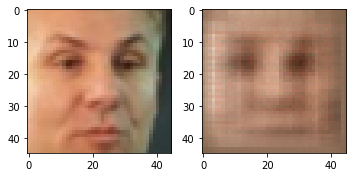

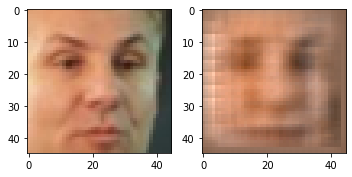

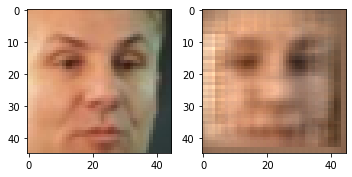

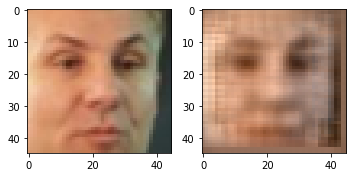

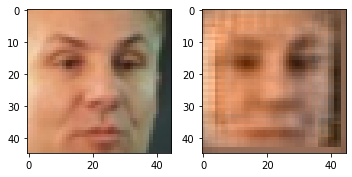

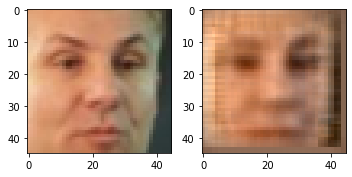

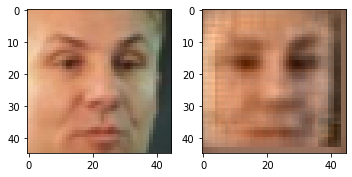

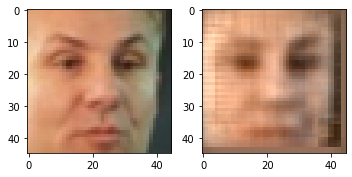

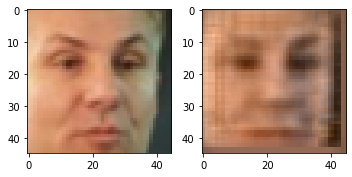

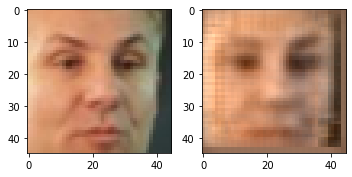

In [49]:
ae_train_losses, ae_val_losses = train(autoencoder, train_loader, val_loader, criterion, optimizer, 10, scheduler)

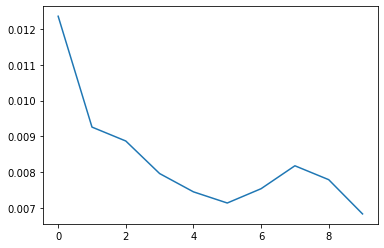

In [50]:
plt.plot(ae_val_losses)

Давайте посмотрим, как наш тренированный автоэекодер кодирует и восстанавливает картинки:

Not bad, right? 

## Sampling

Давайте теперь будем не просто брать картинку, прогонять ее через автоэекодер и получать реконструкцию, а попробуем создать что-то НОВОЕ

Давайте возьмем и подсунем декодеру какие-нибудь сгенерированные нами векторы (например, из нормального распределения) и посмотрим на результат реконструкции декодера:

#### If that doesn't work
Если вместо лиц у вас выводится непонятно что, попробуйте посмотреть, как выглядят латентные векторы картинок из датасета. Так как в обучении нейронных сетей есть определенная доля рандома, векторы латентного слоя могут быть распределены НЕ как np.random.randn(25, <latent_space_dim>). А чтобы у нас получались лица при запихивании вектора декодеру, вектор должен быть распределен так же, как лаьентные векторы реальных фоток. Так что ридется рандом подогнать.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


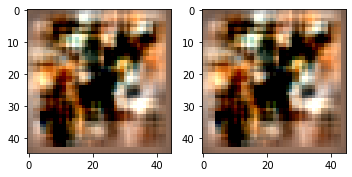

In [22]:
# сгенерируем 25 рандомных векторов размера latent_space
z = np.random.randn(25, 16, 8, 8)
z = torch.FloatTensor(z).to(DEVICE)
output, _ = autoencoder(z, decoder=True)
plot_samples(output, output)

Получить хорошую генерацию лица у меня не получилось, но я сделал "среднее лицо"

In [23]:
mean_val_loader =  data_utils.DataLoader(X_val, batch_size=1, shuffle=False, num_workers=4)
_, mean_code = autoencoder(iter(mean_val_loader).next().to(DEVICE))
for ex in mean_val_loader:
    _, t = autoencoder(ex.to(DEVICE))
    mean_code += t
mean_code /= VAL_SIZE

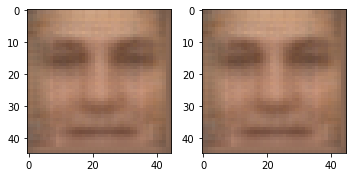

In [24]:
output, _ = autoencoder(mean_code, decoder=True)
plot_samples(output, output)

## Congrats!

Time to make fun!

Давайте научимся пририсовывать людям улыбки =)

<img src="https://i.imgur.com/tOE9rDK.png" alt="linear" width="700" height="400">

План такой:

1) Нужно выделить "вектор улыбки": для этого нужно из выборки изображений найти несколько (~15 сойдет) людей с улыбками и столько же без.

Найти людей с улыбками вам поможет файл с описанием датасета, скачанный вместе с датасетом. В нем указаны имена картинок и присутствубщие атрибуты (улыбки, очки...)

2) Вычислить латентный вектор для всех улыбающихся людей (прогнать их через encoder) и то же для всех грустненьких

3) Вычислить, собственно, вектор улыбки -- посчитать разность между средним латентным вектором улыбающихся людей и средним латентным вектором грустных людей

3) А теперь приделаем улыбку грустному человеку: добавим полученный в пункте 3 вектор к латентному вектору грустного чувака и прогоним полученный вектор через decoder. Получим того же человека, но уже не грустненького!

In [26]:
smiling_numbers = [n for n, x in attrs.iterrows() if x['Smiling'] > 1][:15] 

In [27]:
smiling_numbers

[5, 8, 9, 11, 26, 34, 60, 83, 88, 96, 101, 106, 108, 132, 135]

In [28]:
no_smiling_numbers = [n for n, x in attrs.iterrows() if x['Smiling'] < -1][:15] 

In [29]:
no_smiling_numbers

[6, 10, 17, 22, 48, 49, 50, 53, 55, 56, 62, 63, 70, 71, 74]

In [30]:
smiling_tensors = X_train[smiling_numbers].to(DEVICE)
no_smiling_tensors = X_train[no_smiling_numbers].to(DEVICE)

In [33]:
_, smiling_code = autoencoder(smiling_tensors, encoder=True)
_, no_smiling_code = autoencoder(no_smiling_tensors, encoder=True)

In [35]:
smiling_code_mean = torch.mean(smiling_code, dim=0)
no_smiling_code_mean = torch.mean(no_smiling_code, dim=0)

In [42]:
smile_code = smiling_code_mean - no_smiling_code_mean

In [43]:
smile_code = smile_code.unsqueeze(0)

In [58]:
# sad_man = X_train[min(no_smiling_numbers)]
sad_man = no_smiling_tensors[3]
sad_man = sad_man.unsqueeze(0)

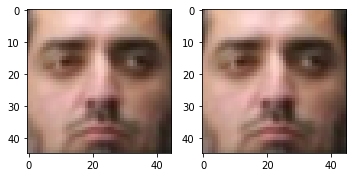

In [59]:
plot_samples(sad_man, sad_man)

In [60]:
_, sad_man_code = autoencoder(sad_man, encoder=True)
smiling_man_code = sad_man_code + smile_code
smiling_man, _ = autoencoder(smiling_man_code, decoder=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


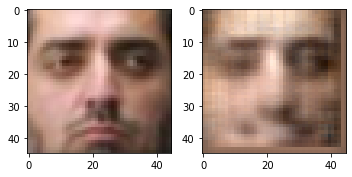

In [61]:
plot_samples(sad_man, smiling_man)

Вуаля! Вы восхитительны!

Теперь вы можете пририсовывать людям не только улыбки, но и много чего другого -- закрывать/открывать глаза, пририсовывать очки... в общем, все, на что хватит фантазии и на что есть атрибуты в lwf_deepfinetuned.txt =)

# Variational Autoencoder. (2 балла) 

Представляю вам проапгрейдженную версию автоэнкодеров -- вариационные автоэнкодеры.

https://towardsdatascience.com/intuitively-understanding-variational-autoencoders-1bfe67eb5daf

In [73]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.eps = 1e-8
        
        self.conv0 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=7, padding=1) # 24x24
        self.bn0 = nn.BatchNorm2d(8)
        self.pl0 = nn.MaxPool2d(2)
        
        self.conv1 = nn.Conv2d(in_channels=8, out_channels=32, kernel_size=5) # 8x8
        self.bn1 = nn.BatchNorm2d(32)
        self.pl1 = nn.MaxPool2d(2)
        
        self.deconv0 = nn.ConvTranspose2d(in_channels=16, out_channels=8, kernel_size=5, stride=2, output_padding=1) # 12x12
        self.bn2 = nn.BatchNorm2d(8)
        
        self.deconv1 = nn.ConvTranspose2d(in_channels=8, out_channels=1, kernel_size=7, stride=2, padding=1, output_padding=1) # 28x28
        self.bn3 = nn.BatchNorm2d(3)

    def encode(self, x):
        downconv0 = F.relu(self.conv0(x))
        downbn0 = self.bn0(downconv0)
        downpl0 = self.pl0(downbn0)

        downconv1 = F.relu(self.conv1(downpl0))
#         downbn1 = self.bn1(downconv1)
        downpl1 = self.pl1(downconv1)

        mu = downpl1[:, :16, ...]
        logsigma = torch.log_(downpl1[:, 16:, ...] + self.eps)
        return mu, logsigma
    
    def gaussian_sampler(self, mu, logsigma):
        """
        Функция сэмплирует латентные векторы из нормального распределения с параметрами mu и sigma
        """
        if self.training:
            std = logsigma.exp()
            eps = Variable(std.data.new(std.size()).normal_())
            return eps.mul(std).add_(mu)
        else:
            return mu
    
    def decode(self, z):
        updeconv0 = F.relu(self.deconv0(z))
        upbn0 = self.bn2(updeconv0)
        
        updeconv1 = F.sigmoid(self.deconv1(upbn0))
        reconstruction = updeconv1
        
        return reconstruction

    def forward(self, x):
        mu, logsigma = self.encode(x)
        sample = self.gaussian_sampler(mu, logsigma)
        reconstruction = self.decode(sample)
        
        return mu, logsigma, reconstruction

In [74]:
class LinearVAE(nn.Module):
    def __init__(self, inp):
        '''определите архитектуры encoder и decoder
        помните, у encoder должны быть два "хвоста", 
        т.е. encoder должен кодировать картинку в 2 переменные -- mu и logsigma'''

        super().__init__()
        self.inp = inp
        self.fc1 = nn.Linear(inp*inp,500)
        self.fc_sig = nn.Linear(500, 100)
        self.fc_mu = nn.Linear(500, 100)
        
        self.fc3 = nn.Linear(100, 500)
        self.fc4 = nn.Linear(500, inp*inp)

    def encode(self, x):
        '''реализуйте forward проход энкодера
        в качестве ваозвращаемых переменных -- mu и logsigma'''
        eps = 1e-5

        x = x.view(-1, self.inp * self.inp )
        x = F.relu(self.fc1(x))
        mu = F.relu(self.fc_mu(x[:]))
        logsigma = torch.log(F.relu(self.fc_sig(x)) + eps)
        return mu, logsigma
    
    def gaussian_sampler(self, mu, logsigma):
        """
        Функция сэмплирует латентные векторы из нормального распределения с параметрами mu и sigma
        """
        if self.training:
            std = logsigma.exp()
            eps = Variable(std.data.new(std.size()).normal_())
            return eps.mul(std).add_(mu)
        else:
            return mu


    def decode(self, z):
        '''реализуйте forward проход декодера
        в качестве ваозвращаемой переменной -- reconstruction'''

        z = F.relu(self.fc3(z))
        reconstruction = F.sigmoid(self.fc4(z))
        return reconstruction

    def forward(self, x):
        '''<используя encode и decode, реализуйте forward проход автоэнкодера
        в качестве ваозвращаемых переменных -- mu, logsigma и reconstruction>'''

        mu, logsigma = self.encode(x)
        z = self.gaussian_sampler(mu, logsigma)
        reconstruction = self.decode(z)
        

        return mu, logsigma, reconstruction.view(-1, 1, self.inp, self.inp)

Определим лосс и его компоненты для VAE:

Надеюсь, вы уже прочитали материал в towardsdatascience (или еще где-то) про VAE и знаете, что лосс у VAE состоит из двух частей: KL и log-likelihood.

Общий лосс будет выглядеть так:

$$\mathcal{L} = -D_{KL}(q_{\phi}(z|x)||p(z)) + \log p_{\theta}(x|z)$$

Формула для KL-дивергенции:

$$D_{KL} = -\frac{1}{2}\sum_{i=1}^{dimZ}(1+log(\sigma_i^2)-\mu_i^2-\sigma_i^2)$$

В качестве log-likelihood возьмем привычную нам кросс-энтропию.

In [75]:
def KL_divergence(mu, logsigma):
    """
    часть функции потерь, которая отвечает за "близость" латентных представлений разных людей
    """
    sigma = logsigma.exp_()
    loss = (-0.5)*(1+2*logsigma-mu*mu-sigma*sigma)
    return loss

def log_likelihood(x, reconstruction):
    """
    часть функции потерь, которая отвечает за качество реконструкции (как mse в обычном autoencoder)
    """
    loss = nn.BCELoss()
    return loss(reconstruction, x)

def loss_vae(x, mu, logsigma, reconstruction):
    return (-KL_divergence(mu, logsigma) + log_likelihood(x, reconstruction)).mean()

И обучим модель:

In [76]:
def plot_mnist(sam1, sam2):
    sam1 = sam1[0].cpu().detach().numpy()
    sam2 = sam2[0].cpu().detach().numpy()
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(5, 3))
    axes[0].imshow(sam1.reshape(28,28))
    axes[1].imshow(sam2.reshape(28,28))
    fig.tight_layout()

In [77]:
vae = VAE().to(DEVICE)

optimizer = torch.optim.Adam(vae.parameters(), lr = 0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.2)
criterion = loss_vae

In [78]:
mnist_train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                             ])),
  batch_size=16, shuffle=True)

mnist_val_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor()
                             ])),
  batch_size=16, shuffle=False)

In [79]:
def mnist_train_epoch(net, train_loader, loss_fn, optimizer):
    net.train()
    train_ep_loss = 0.
    counter = 0
    for train_x in train_loader:
        train_x = train_x[0].to(DEVICE)
        
        # zero  gradients
        optimizer.zero_grad()

        # get the output from the model
        mu, logsigma, reconstruction = net(train_x)
        
        # calculate loss
        
        loss = loss_fn(train_x, mu, logsigma, reconstruction)
        loss.backward()
        optimizer.step()

        train_ep_loss += loss.item() 
        counter += 1
    train_ep_loss /= counter

   
    return train_ep_loss

In [80]:
def mnist_val_epoch(net, val_loader, loss_fn):
    net.eval()
    val_ep_loss = 0.
    counter = 0.
    for val_x in val_loader:
        # get the output from the model
        val_x = val_x[0].to(DEVICE)
        mu, logsigma, reconstruction = net(val_x)
        
        # calculate loss
        
        loss = loss_fn(val_x, mu, logsigma, reconstruction)
        val_ep_loss += loss.item() 
        
        counter += 1

    val_ep_loss /= counter
    rand = np.random.randint(16)
    plot_mnist(val_x[rand], reconstruction[rand])
    
    return val_ep_loss

In [81]:
def mnist_train(net, train_loader, val_loader, loss_fn, optimizer, epochs, scheduler=None):
    
    train_losses = []
    val_losses = []

    for e in tqdm(range(epochs)):

        train_loss = mnist_train_epoch(net, train_loader, loss_fn, optimizer)
        if scheduler:
            scheduler.step()
        with torch.no_grad():
            val_loss = mnist_val_epoch(net, val_loader, loss_fn)

        train_losses.append(train_loss)
        val_losses.append(val_loss)


        print("Epoch: {}/{}...".format(e+1, epochs),
                      "Loss: {:.6f}...".format(train_loss),
                      "Val Loss: {:.6f}".format(val_loss))
    return train_losses, val_losses

  0%|          | 0/10 [00:00<?, ?it/s]/home/philipp/anaconda3/envs/autoencoder/lib/python3.7/site-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
 10%|█         | 1/10 [00:31<04:46, 31.83s/it]

Epoch: 1/10... Loss: -2013572723052.694824... Val Loss: -7626030689602.764648


 20%|██        | 2/10 [01:02<04:11, 31.44s/it]

Epoch: 2/10... Loss: -35549433554796.546875... Val Loss: -71435710301523.156250


 30%|███       | 3/10 [01:30<03:33, 30.47s/it]

Epoch: 3/10... Loss: -164046354889170.406250... Val Loss: -279832963683503.312500


 40%|████      | 4/10 [02:00<03:02, 30.42s/it]

Epoch: 4/10... Loss: -467038782235309.937500... Val Loss: -843191757887137.375000


 50%|█████     | 5/10 [02:30<02:30, 30.05s/it]

Epoch: 5/10... Loss: -1041830674458424.125000... Val Loss: -1556189332464520.500000


 60%|██████    | 6/10 [03:02<02:02, 30.74s/it]

Epoch: 6/10... Loss: -2004519841120334.750000... Val Loss: -2449500029291017.000000


 70%|███████   | 7/10 [03:34<01:33, 31.00s/it]

Epoch: 7/10... Loss: -3486993471129832.500000... Val Loss: -4462354597295004.000000


 80%|████████  | 8/10 [04:02<01:00, 30.32s/it]

Epoch: 8/10... Loss: -5642480741794884.000000... Val Loss: -6804227552431414.000000


 90%|█████████ | 9/10 [04:33<00:30, 30.55s/it]

Epoch: 9/10... Loss: -8634122689287693.000000... Val Loss: -12586311851443854.000000


100%|██████████| 10/10 [05:05<00:00, 30.54s/it]

Epoch: 10/10... Loss: -12646016563769718.000000... Val Loss: -13964463968211698.000000


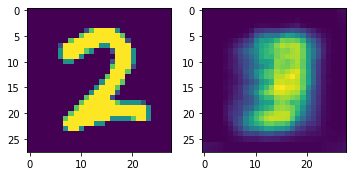

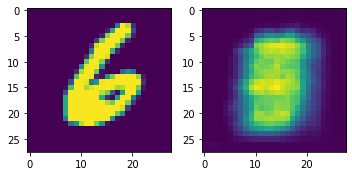

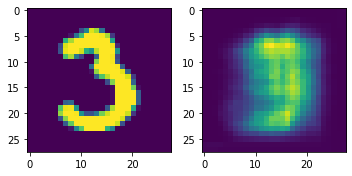

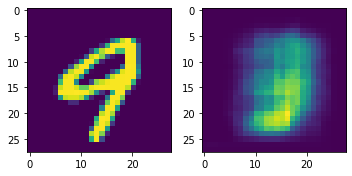

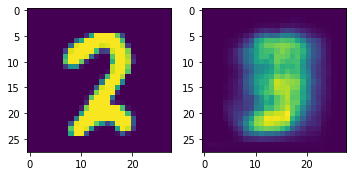

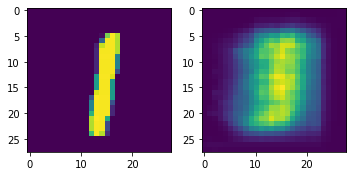

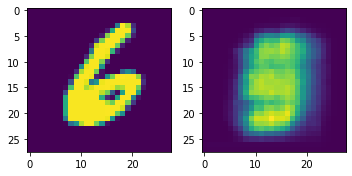

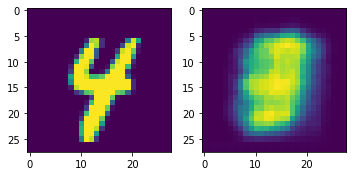

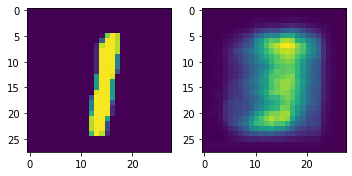

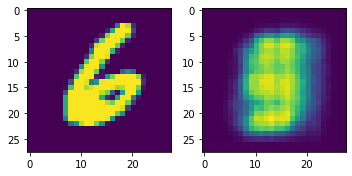

In [82]:
vae_train_losses, vae_val_losses = mnist_train(vae, mnist_train_loader, mnist_val_loader, criterion, optimizer, 10, scheduler)

Давайте посмотрим, как наш тренированный VAE кодирует и восстанавливает картинки:

In [40]:
def plot_10(output, data):
    output = output.cpu().detach().numpy()
    data = data.cpu().detach().numpy()

    fig, axes = plt.subplots(nrows=2, ncols=10, figsize=(20, 3))
    for ii, ax in enumerate(axes[0].flatten()):
        ax.imshow(data[ii].reshape(28,28))

    for ii, ax in enumerate(axes[1].flatten()):
        ax.imshow(output[ii].reshape(28,28))
    fig.tight_layout()

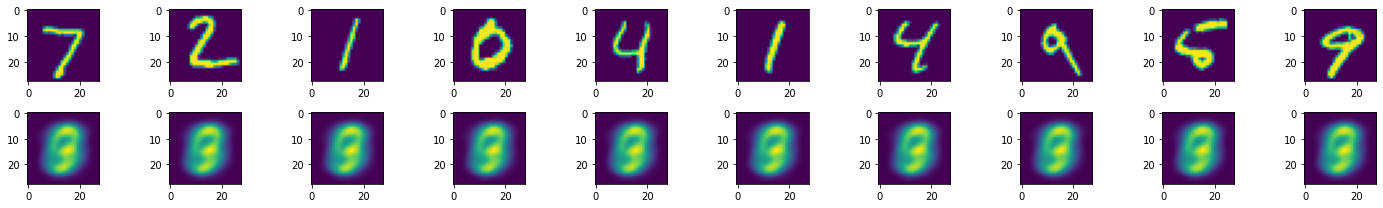

In [41]:
mnist_val_10 = iter(mnist_val_loader).next()[0]
_, _, output = vae(mnist_val_10[:10, ...].to(DEVICE))
plot_10(output, mnist_val_10)

And finally sample from VAE.

## Sampling

Давайте попробуем проделать для VAE то же, что и с обычным автоэнкодером -- подсунуть decoder'у из VAE случайные векторы из нормального распределения и посмотреть, какие картинки получаются:

In [85]:
# вспомните про замечание из этого же пункта обычного AE про распределение латентных переменных
z = np.random.normal(0, 1, size=(10, 16, 4, 4))
z = torch.FloatTensor(z).to(DEVICE)
output = vae.decode(z)
# plot_gallery(output.data.cpu().numpy(), IMAGE_H, IMAGE_W, n_row=2, n_col=5)

/home/philipp/anaconda3/envs/autoencoder/lib/python3.7/site-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [86]:
output.shape

torch.Size([10, 1, 28, 28])

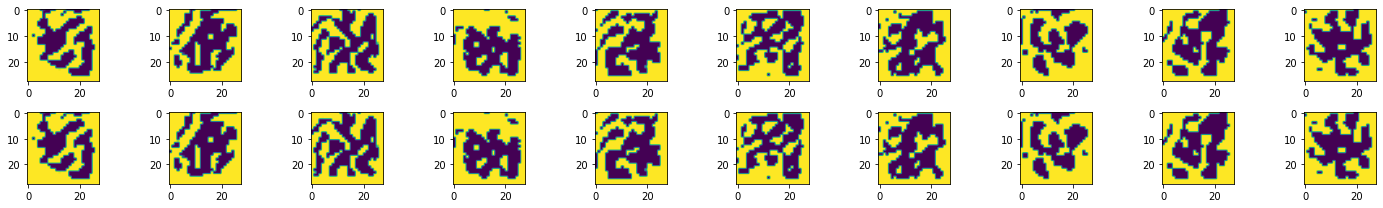

In [89]:
plot_10(output, output)

## Latent Representation

Давайте посмотрим, как латентные векторы картинок лиц выглядят в пространстве.
Ваша задача -- изобразить латентные векторы картинок точками в двумерном просторанстве. 

Это позволит оценить, насколько плотно распределены латентные векторы лиц в пространстве. 

Плюс давайте сделаем такую вещь: у вас есть файл с атрибутами lwf_deepfinetuned.txt, который скачался вместе с базой картинок. Там для каждой картинки описаны атрибуты картинки (имя человека, его пол, цвет кожи и т.п.). Когда будете визуализировать точки латентного пространства на картинке, возьмите какой-нибудь атрибут и покрасьте точки в соответствии со значем атрибута, соответствующего этой точке. 

Например, возьмем атрибут "пол". Давайте покрасим точки, которые соответствуют картинкам женщин, в один цвет, а точки, которые соответствуют картинкам мужчин -- в другой.

Подсказка: красить -- это просто =) У plt.scatter есть параметр c (color), см. в документации.


Итак, план:
1. Получить латентные представления картинок тестового датасета
2. С помощтю TSNE (есть в sklearn) сжать эти представления до размерности 2 (чтобы можно было их визуализировать точками в пространстве)
3. Визуализировать полученные двумерные представления с помощью matplotlib.scatter, покрасить разными цветами точки, соответствующие картинкам с разными атрибутами.

In [71]:
import gc
gc.collect()

22

In [72]:
_, ae_output = autoencoder(X_val.to(DEVICE), encoder=True)

RuntimeError: CUDA out of memory. Tried to allocate 162.00 MiB (GPU 0; 1.96 GiB total capacity; 947.98 MiB already allocated; 60.94 MiB free; 20.02 MiB cached)

Что вы думаете о виде латентного представления?

## Congrats v2.0!

# Conditional VAE (2 балла)


Мы уже научились обучать обычный AE на датасете картинок и получать новые картинки, используя генерацию шума и декодер. 
Давайте теперь допустим, что мы обучили AE на датасете MNIST и теперь хотим генерировать новые картинки с числами с помощью декодера (как выше мы генерили рандомные лица). 
И вот мне понадобилось сгенерировать цифру 8. И я подставляю разные варианты шума, и все никак не генерится восьмерка -- у меня получаются то пятерки, то тройки, то четверки. Гадость(

  Хотелось бы добавить к нашему AE функцию "выдай мне пожалуйста рандомное число из вот этого вот класса", где классов десять (цифры от 0 до 9 образуют десять классов).
  Типа я такая говорю "выдай мне случайную восьмерку" и оно генерит случайную восьмерку!

Conditional AE -- так называется вид автоэнкодера, который предоставляет такую возможность. Ну, название "conditional" уже говорит само за себя.

И в этой части проекта мы научимся такие обучать.

## Архитектура

На картинке ниже представлена архитектура простого Conditional AE.

По сути, единственное отличие от обычного -- это то, что мы вместе с картинкой в первом слое энкодера и декодера передаем еще информацию о классе картинки. 

То есть, в первый (входной) слой энкодера есть конкатенация картинки и информации о классе (например, вектора из девяти нулей и одной единицы). Первый слой декодера есть конкатенация латентного вектора и информации о классе.


![alt text](https://i.ibb.co/2tsWknB/Screen-Shot-2020-01-15-at-9-02-15-PM.png)



На всякий случай: это VAE, то есть, latent у него состоит из mu и sigma все еще.

Таким образом, при генерации новой рандомной картинки мы должны будем передать декодеру сконкатенированные латентный вектор и класс картинки.

### P.S.
Можно ередавать класс картинки не только в первый слой, но и в каждый слой сети. То есть на каждом слое конкатенировать выход из предыдущего слоя и информацию о классе.

### Датасет
Здесь я предлагаю вам два вариана. Один попроще, другой -- посложнее, но поинтереснее =)

1. Использовать датасет MNIST (http://yann.lecun.com/exdb/mnist/). Обучать conditional VAE на этом датасете, condition -- класс цифры. 

2. Использовать датасет лиц, с которым мы игрались выше. Condition -- пол/раса/улыбки/whatever из lfw_deepfinetuned.txt. 

Почему второй вариант "посложнее" -- потому что я сама еще не знаю, получится ли такой CVAE с лицами или нет =) Вы -- исследователи! (не ну это же проект, так и должно быть)

In [ ]:
<тут ваш код объявления CVAE, лосса, оптимизатора и тренировки>

## Sampling


Тут мы будем сэмплировать из CVAE. Это прикольнее, чем сэмплировать из простого AE/VAE: тут можно взять один и тот же латентный вектор и попросить CVAE восстановить из него картинки разных классов!
Для MNIST вы можете попросить CVAE восстановить из одного латентного вектора картинки цифры 5 и 7, а для лиц людей -- восстановить лицо улыбающегося и хмурого человека или лица людей разного пола (смотря на чем был ваш кондишен)

In [ ]:
<тут нужно научиться сэмплировать из декодера цифры определенного класса>

Splendid! Вы великолепны!

Ну круто же, ну?

## Latent Representations

Давайте посмотрим, как выглядит латентное пространство картинок в CVAE и сравним с картинкой для VAE =)

Опять же, нужно покрасить точки в разные цвета в зависимости от класса.

In [ ]:
<ваш код получения латентных представлений, применения TSNE и визуализации>

Что вы думаете насчет этой картинки? Отличается от картинки для VAE?

# BONUS 1: Image Morphing (1 балл) 

<a href="https://ibb.co/rxr9YgL"><img src="https://i.ibb.co/D92dhN6/1-6y-Okto2-BUp-ONJpk5x-LRMtw.png" alt="1-6y-Okto2-BUp-ONJpk5x-LRMtw" border="0"></a>

Предлагаю вам поиграться не только с улыбками, но и с получением из одного человека другого!

План:
1. Берем две картинки разных людей из датасета
2. Получаем их латентные представления X и Y
3. Складываем латентные представления с коэффициентом $\alpha$:
  $$\alpha X + (1-\alpha) Y$$
  где $\alpha$ принимает несколько значений от 0 до 1 
4. Визуализируем, как один человек превращается в другого!

In [ ]:
<тут ваш код>

# BONUS 2: Denoising (2 балла) 

У автоэнкодеров, кроме сжатия и генерации изображений, есть другие практические применения. Про одно из них это бонусное задание.

Автоэнкодеры могут быть использованы для избавления от шума на фотографиях (denoising). Для этого их нужно обучить специальным образом: input картинка будет зашумленной, а выдавать автоэнкодер должен будет картинку без шума. 
То есть, loss-функция AE останется той же (MSE между реальной картинкой и выданной), а на вход автоэнкодеру будет подаваться зашумленная картинка.

<a href="https://ibb.co/YbRJ1nZ"><img src="https://i.ibb.co/0QD164t/Screen-Shot-2020-06-04-at-4-49-50-PM.png" alt="Screen-Shot-2020-06-04-at-4-49-50-PM" border="0"></a>

Для того, чтобы поставить эксперимент, нужно взять ваш любимый датасет (датасет лиц или MSE с прошлых заданий или любой другой) и сделать копию этого датасета с шумом. 

В питоне шум можно добавить так:

In [ ]:
noise_factor = 0.5
X_noisy = X + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X.shape) 

In [ ]:
<тут ваш код обучения автоэнкодера на зашумленных картинках. Не забудтье разбить на train/test!>

In [ ]:
<тут проверка, как AE убирает щум с тестовых картинок. Надеюсь, все получилось =)>

## Бонус 2.1: Occlusion (+еще 1 балл)

<a href="https://imgbb.com/"><img src="https://i.ibb.co/wYrKtQY/Screen-Shot-2020-06-04-at-5-06-35-PM.png" alt="Screen-Shot-2020-06-04-at-5-06-35-PM" border="0" width="300" height="300"></a>

Автоэнкодерами можно не только убирать шум, но и восстанавливать части картинки, которые чем-то закрыты! 

Эксперимент здесь такой: вместо наложения шума на картинку, "закрываем" часть картинки заплаткой и тренируем AE/VAE восстанавливать закрытую часть картинки.

Важно, чтобы заплатка была не очень большая. 

In [ ]:
<тут ваш код обучения автоэнкодера на occluded (простите, не знаю, как это сказать по-русски) картинках. Не забудтье разбить на train/test!>

# Bonus 3: Image Retrieval (2 балла)

Давайте представим, что весь наш тренировочный датасет -- это большая база данных людей. И вот мы получили картинку лица какого-то человека с уличной камеры наблюдения (у нас это картинка из тестового датасета) и хотим понять, что это за человек. Что нам делать? Правильно -- берем наш VAE, кодируем картинку в латентное представление и ищем среди латентныз представлений лиц нашей базы самые ближайшие!

План:

1. Получаем латентные представления всех лиц тренировочного датасета
2. Обучаем на них LSHForest (sklearn.neighbors.LSHForest), например, с n_estimators=50
3. Берем картинку из тестового датасета, с помощью VAE получаем ее латентный вектор
4. Ищем с помощью обученного LSHForest ближайшие из латентных представлений тренировочной базы
5. Находим лица тренировочного датасета, которым соответствуют ближайшие латентные представления, визуализируем!

Немного кода вам в помощь: (feel free to delete everything and write your own)

In [ ]:
codes = <поучите латентные представления картинок из трейна>

In [ ]:
# обучаем LSHForest
from sklearn.neighbors import LSHForest
lshf = LSHForest(n_estimators=50).fit(codes)

In [ ]:
def get_similar(image, n_neighbors=5):
  # функция, которая берет тестовый image и с помощью метода kneighbours у LSHForest ищет ближайшие векторы
  # прогоняет векторы через декодер и получает картинки ближайших людей

  code = <получение латентного представления image>
    
  (distances,),(idx,) = lshf.kneighbors(code, n_neighbors=n_neighbors)

  return distances, X_train[idx]

In [ ]:
def show_similar(image):

  # функция, которая принимает тестовый image, ищет ближайшие к нему и визуализирует результат
    
    distances,neighbors = get_similar(image,n_neighbors=11)
    
    plt.figure(figsize=[8,6])
    plt.subplot(3,4,1)
    plt.imshow(image.cpu().numpy().transpose([1,2,0]))
    plt.title("Original image")
    
    for i in range(11):
        plt.subplot(3,4,i+2)
        plt.imshow(neighbors[i].cpu().numpy().transpose([1,2,0]))
        plt.title("Dist=%.3f"%distances[i])
    plt.show()

# Эпилог

здесь мы рассмотрели не все применения автоэнкодеров. Еще есть, например:

-- поиск аномалий
-- дополнение отсутствующих частей картины
-- работа с sequential данными (например, временными рядами)
-- гибриды ГАН+АЕ, которые активно изучаются в последнее время
-- использование латентных переменных АЕ в качестве фичей
...

Они не были частью этого проекта, потому что для их реализации пришлось бы больше возиться с датасетами. 

Но! Если вы хотите, вы, конечно, всегда можете реализовать еще что-то и получить за это еще допбаллы.

Надеюсь, вам понравилось!